# Knowledge Graph Completion on YAGO3-10

<em>Copyright (c) 2023 Graphcore Ltd. All rights reserved.</em>

BESS-KGE (`besskge`) is a PyTorch library for knowledge graph embedding (KGE) models on IPUs implementing the distribution framework [BESS](https://arxiv.org/abs/2211.12281), with embedding tables stored in the IPU SRAM.

In this notebook we will show how to use the BESS-KGE package to perform knowledge graph completion on the YAGO3-10 dataset, a subset of [YAGO3](https://yago-knowledge.org/downloads/yago-3) (Yet Another Great Ontology 3) containing only entities with at least ten relations associated to them.

In particular, we will learn how to use the `TopKQueryBessKGE` BESS distribution scheme to efficiently score queries against all entities in the knowledge graph and retrieve the most likely triple completions. 

If you have not already done so, we suggest running the [KGE Training and Inference on OGBL-BioKG](1_biokg_training_inference.ipynb) notebook to get familiar with the basic functionalities of the BESS-KGE library.

## Environment setup

To run the demo using IPU hardware, you need to have the Poplar SDK enabled and a PopTorch wheel installed. Refer to the [Getting Started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to do this. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.

## Dependencies

We recommend that you install `besskge` directly from the GitHub sources:

In [4]:
import sys
!{sys.executable} -m pip uninstall -y besskge
!pip install -q git+https://github.com/graphcore-research/bess-kge.git

!pip install -q matplotlib

Found existing installation: besskge 0.1
Uninstalling besskge-0.1:
  Successfully uninstalled besskge-0.1


Next, import the necessary dependencies. 

In [1]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import poptorch
import torch

from besskge.batch_sampler import RigidShardedBatchSampler
from besskge.bess import EmbeddingMovingBessKGE, TopKQueryBessKGE
from besskge.dataset import KGDataset
from besskge.loss import LogSigmoidLoss
from besskge.metric import Evaluation
from besskge.negative_sampler import (
    PlaceholderNegativeSampler,
    RandomShardedNegativeSampler,
)
from besskge.scoring import ComplEx
from besskge.sharding import PartitionedTripleSet, Sharding

dataset_directory = os.getenv("DATASET_DIR", "../datasets/") + "/yago310/"

## Entity sharding and triple partitioning

Download and preprocess the dataset with the built-in method of `KGDataset`, `build_yago310`.

You can use the `entity_dict` and `relation_dict` attributes of the `KGDataset` object to go from entity/relation IDs to labels.

In [2]:
yago = KGDataset.build_yago310(root=pathlib.Path(dataset_directory))

print(f"Number of entities: {yago.n_entity:,}\n")
print(f"Number of relation types: {yago.n_relation_type}\n")
print(
    f"Number of triples: \n training: {yago.triples['train'].shape[0]:,} \n validation/test: {yago.triples['valid'].shape[0]:,}\n"
)

# Print example triple retrieving labels from yago.entity_dict and yago.relation_dict
ex_triple_id = 2500
ex_triple = yago.triples["train"][ex_triple_id]
print(
    f"Example triple: {yago.entity_dict[ex_triple[0]], yago.relation_dict[ex_triple[1]], yago.entity_dict[ex_triple[2]]}"
)

Number of entities: 123,182

Number of relation types: 37

Number of triples: 
 training: 1,079,040 
 validation/test: 5,000

Example triple: ('Charles_VIII_of_France', 'isMarriedTo', 'Anne_of_Brittany')


We want to train on 4 IPUs, so we construct a sharding of the entity table in 4 parts. The entity sharding induces a sharding of the triples into 4*4=16 shard-pairs, based on the shard of head and tail entities.

In [3]:
seed = 12345
n_shard = 4

sharding = Sharding.create(yago.n_entity, n_shard=n_shard, seed=seed)
print(f"Global entity IDs on {n_shard} shards:")
print(sharding.shard_and_idx_to_entity)

# The global entity IDs can be recovered, as a function of the shard ID and the local ID on the shard, by
print("\nReconstructed global entity IDs:")
print(
    sharding.shard_and_idx_to_entity[sharding.entity_to_shard, sharding.entity_to_idx]
)

train_triples = PartitionedTripleSet.create_from_dataset(yago, "train", sharding)

print("\nNumber of triples per (h,t) shard-pair:")
print(train_triples.triple_counts)

Global entity IDs on 4 shards:
[[     1      4      5 ... 123174 123176 123177]
 [    12     22     25 ... 123179 123180 123182]
 [     6      7     11 ... 123166 123168 123175]
 [     0      2      3 ... 123178 123181 123183]]

Reconstructed global entity IDs:
[     0      1      2 ... 123179 123180 123181]

Number of triples per (h,t) shard-pair:
[[80014 68072 62429 58933]
 [79964 68351 62451 59671]
 [80045 69389 62231 58903]
 [79919 67988 62046 58634]]


To iterate over the sharded set of triples we use a batch sampler.
At each step, `RigidShardedBatchSampler` consumes the same number of triples from all 16 shard-pairs
(resampling from the shorter ones, until the longest one is completed).

To sample negatives during training we use a negative sampler. 
`RandomShardedNegativeSampler` constructs, for each triple, negative samples by sampling random corrupted entities.

See the [KGE Training and Inference on OGBL-BioKG](1_biokg_training_inference.ipynb) notebook for more details on the options for these class.

In [4]:
device_iterations = 20
accum_factor = 2
shard_bs = 720
neg_sampler = RandomShardedNegativeSampler(
    n_negative=1,
    sharding=sharding,
    seed=seed,
    corruption_scheme="ht",
    local_sampling=False,
    flat_negative_format=False,
)
bs = RigidShardedBatchSampler(
    partitioned_triple_set=train_triples,
    negative_sampler=neg_sampler,
    shard_bs=shard_bs,
    batches_per_step=device_iterations * accum_factor,
    seed=seed,
)

In [5]:
options = poptorch.Options()
options.replication_factor = sharding.n_shard
options.deviceIterations(device_iterations)
options.Training.gradientAccumulation(accum_factor)
options._popart.setPatterns(dict(RemoveAllReducePattern=True))

# Construct the dataloader with the dedicated utility function
train_dl = bs.get_dataloader(
    options=options, shuffle=True, num_workers=5, persistent_workers=True
)

# Example batch
batch = next(iter(train_dl))
for k, v in batch.items():
    print(f"{k:<12} {str(v.shape):<30}")

head         torch.Size([40, 4, 4, 180])   
relation     torch.Size([40, 4, 4, 180])   
tail         torch.Size([40, 4, 4, 180])   
triple_mask  torch.Size([40, 4, 4, 180])   
negative     torch.Size([40, 4, 4, 720, 1])


## Training

Let's train the **ComplEx** KGE model with complex embedding size of 128 and the **logsigmoid** loss function, using the `EmbeddingMovingBessKGE` distribution scheme.

In [6]:
loss_fn = LogSigmoidLoss(margin=12.0, negative_adversarial_sampling=True)
complex_score_fn = ComplEx(
    negative_sample_sharing=True,
    sharding=sharding,
    n_relation_type=yago.n_relation_type,
    embedding_size=128,
)
model = EmbeddingMovingBessKGE(
    negative_sampler=neg_sampler, score_fn=complex_score_fn, loss_fn=loss_fn
)

print(f"# model parameters: {model.n_embedding_parameters:,}")

# model parameters: 31,544,576


To follow training evolution, let us compute at regular intervals the MRR for tail prediction on a small random subset of 500 validation queries. Since no candidate tails are provided in this dataset, we score each query against all entities in the knowledge graph and select the top-10 candidate tails with largest scores. We then rank the ground truth tail among the ordered predictions. By setting `worst_rank_infty=True` in the `Evaluation` module, we assign a reciprocal rank of 0 (or a rank of infinity) if the ground truth is not among the top-10 predictions made by the model.

As the number of entities in the knowledge graph is not so large, we can afford to score the queries on the CPU. To see how to speed up this task on IPUs (which is necessary on graphs with more entities, or when scoring a large number of queries), see the [Top-k inference on IPU](#top-k-inference-on-ipu) section.

In [7]:
def evaluate_mrr_cpu(triples, evaluation):
    # Unshard entity embedding table
    ent_table = complex_score_fn.entity_embedding.detach()[
        sharding.entity_to_shard, sharding.entity_to_idx
    ]

    # Score query (h,r,?) against all entities in the knowledge graph and select top-10 scores
    scores = complex_score_fn.score_tails(
        ent_table[triples[:, 0]],
        torch.from_numpy(triples[:, 1]),
        ent_table.unsqueeze(0),
    )
    top_k = torch.topk(scores, dim=-1, k=10)

    # Use evaluation.ranks_from_indices to rank the ground truth, if present, among the predictions
    ranks = evaluation.ranks_from_indices(
        torch.from_numpy(triples[:, 2]), top_k.indices.squeeze()
    )
    return {
        k: v / triples.shape[0]
        for k, v in evaluation.dict_metrics_from_ranks(ranks).items()
    }


# Sample validation queries
n_val_triples = 500
val_triple_subset = yago.triples["valid"][
    np.random.default_rng(seed=1000).choice(
        yago.triples["valid"].shape[0], n_val_triples
    )
]
evaluation = Evaluation(["mrr"], worst_rank_infty=True, reduction="sum")

In [8]:
opt = poptorch.optim.AdamW(
    model.parameters(),
    lr=0.0016,
)

poptorch_model = poptorch.trainingModel(model, options=options, optimizer=opt)

# The variable entity_embedding needs to hold different values on each replica,
# corresponding to the shards of the entity embedding table
poptorch_model.entity_embedding.replicaGrouping(
    poptorch.CommGroupType.NoGrouping,
    0,
    poptorch.VariableRetrievalMode.OnePerGroup,
)

# Graph compilation
_ = batch.pop("triple_mask")
res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

Graph compilation: 100%|██████████| 100/100 [00:47<00:00]


Epoch 1 loss: 4.582457 --- positive triples processed: 1.38e+06
Epoch duration (sec): 0.59385 (average step time: 0.03974)
Epoch 1 sample MRR: 0.0000
Epoch 2 loss: 0.980555 --- positive triples processed: 2.76e+06
Epoch duration (sec): 0.47770 (average step time: 0.03968)
Epoch 3 loss: 0.749413 --- positive triples processed: 4.15e+06
Epoch duration (sec): 0.47638 (average step time: 0.03960)
Epoch 4 loss: 0.707479 --- positive triples processed: 5.53e+06
Epoch duration (sec): 0.47575 (average step time: 0.03955)
Epoch 5 loss: 0.675585 --- positive triples processed: 6.91e+06
Epoch duration (sec): 0.47491 (average step time: 0.03948)
Epoch 6 loss: 0.673483 --- positive triples processed: 8.29e+06
Epoch duration (sec): 0.47486 (average step time: 0.03949)
Epoch 6 sample MRR: 0.0809
Epoch 7 loss: 0.660370 --- positive triples processed: 9.68e+06
Epoch duration (sec): 0.47620 (average step time: 0.03958)
Epoch 8 loss: 0.651325 --- positive triples processed: 1.11e+07
Epoch duration (sec):

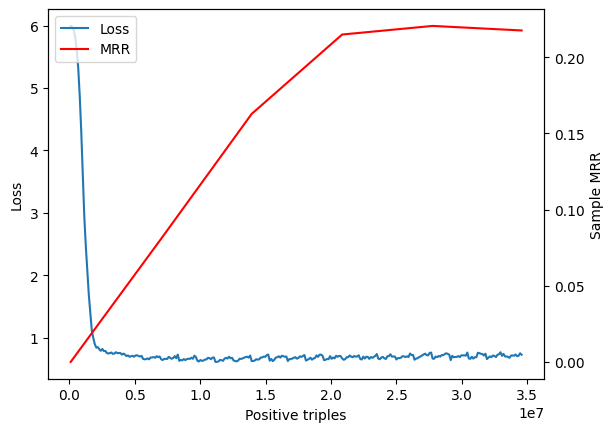

In [9]:
# Train on IPU with interleaved validation on CPU

n_epochs = 25
val_ep_interval = 5

cumulative_triples = 0
training_loss = []
val_mrr = []
for ep in range(n_epochs):
    ep_start_time = time.time()
    ep_log = []
    for batch in train_dl:
        step_start_time = time.time()
        triple_mask = batch.pop("triple_mask")
        cumulative_triples += triple_mask.numel()
        res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})
        ep_log.append(
            dict(
                loss=float(torch.sum(res["loss"])) / triple_mask[-1].numel(),
                step_time=(time.time() - step_start_time),
            )
        )
    ep_loss = [v["loss"] for v in ep_log]
    training_loss.extend([v["loss"] for v in ep_log])
    print(
        f"Epoch {ep+1} loss: {np.mean(ep_loss):.6f} --- positive triples processed: {cumulative_triples:.2e}"
    )
    print(
        f"Epoch duration (sec): {(time.time() - ep_start_time):.5f} (average step time: {np.mean([v['step_time'] for v in ep_log]):.5f})"
    )
    if ep % val_ep_interval == 0:
        ep_mrr = evaluate_mrr_cpu(val_triple_subset, evaluation)["mrr"]
        val_mrr.append(ep_mrr)
        print(f"Epoch {ep+1} sample MRR: {ep_mrr:.4f}")
ep_mrr = evaluate_mrr_cpu(val_triple_subset, evaluation)["mrr"]
val_mrr.append(ep_mrr)
print(f"Final sample MRR: {ep_mrr:.4f}")

# Plot loss and sample MRR as a function of the number of positive triples processed
total_triples = np.cumsum(n_epochs * len(train_dl) * [triple_mask.numel()])
ax0, ax1 = plt.gca(), plt.twinx()
(line0,) = ax0.plot(total_triples, training_loss)
(line1,) = ax1.plot(
    np.concatenate(
        [total_triples[:: val_ep_interval * len(train_dl)], total_triples[-1:]]
    ),
    val_mrr,
    color="r",
)
ax0.set_xlabel("Positive triples")
ax0.set_ylabel("Loss")
ax1.set_ylabel("Sample MRR")
plt.legend([line0, line1], ["Loss", "MRR"])

poptorch_model.detachFromDevice()
del train_dl

The fact that we are seeing lower metric values compared to the [KGE Training and Inference on OGBL-BioKG](1_biokg_training_inference.ipynb) case study is not surprising, as we are now making predictions choosing from all 123k+ entities in the knowledge graph, while for OGB-BioKG we only had to rank the ground truth against a small set of 500 candidate heads/tails.

## Top-k inference on IPU

On the IPU we use the BESS `TopKQueryBessKGE` distribution scheme to predict, for each validation query, the top-k most likely tails among all the entities in the knowledge graph. Since there are no specific tail candidates to sample, our dataloader does not need to pass negative indices to the IPUs. We therefore use the `PlaceholderNegativeSampler` class.

When using `TopKQueryBessKGE` we partition triples based just on the shard of the head entity (or the tail entity, if we wanted to predict heads), specifying `partition_mode='h_shard'` when constructing the `PartitionedTripleSet`.

Since we want to inspect the predictions made by the model, we ask the dataloader to return the indices (with respect to the ordered list `validation_triples.triples`) of the triples in the batches, by setting the flag `return_triple_idx=True` when creating the `RigidShardedBatchSampler` batch sampler.

In [16]:
device_iterations = 1
shard_bs = 1440

validation_triples = PartitionedTripleSet.create_from_dataset(
    yago, "valid", sharding, partition_mode="h_shard"
)
candidate_sampler = PlaceholderNegativeSampler(corruption_scheme="t", seed=seed)
bs_valid = RigidShardedBatchSampler(
    partitioned_triple_set=validation_triples,
    negative_sampler=candidate_sampler,
    shard_bs=shard_bs,
    batches_per_step=device_iterations,
    seed=seed,
    duplicate_batch=False,
    return_triple_idx=True,
)

print("Number of triples per h_shard:")
print(validation_triples.triple_counts)

Number of triples per h_shard:
[1196 1273 1286 1245]


In [17]:
val_options = poptorch.Options()
val_options.replication_factor = sharding.n_shard
val_options.deviceIterations(bs_valid.batches_per_step)
val_options.outputMode(poptorch.OutputMode.All)

valid_dl = bs_valid.get_dataloader(
    options=val_options, shuffle=False, num_workers=5, persistent_workers=True
)

# Example batch
batch = next(iter(valid_dl))
for k, v in batch.items():
    print(f"{k:<12} {str(v.shape):<30}")

head         torch.Size([1, 4, 1440])      
relation     torch.Size([1, 4, 1440])      
tail         torch.Size([1, 4, 1440])      
triple_mask  torch.Size([1, 4, 1440])      
triple_idx   torch.Size([1, 4, 1440])      


As explained above, `triple_idx` contains the indices of the triple in the batch.  

Notice that, when constructing the partitioned triple set with `partition_mode='h_shard'`, the tensor `head` will contain the **local** entity IDs in the corresponding shard, while `tail` contains the **global** IDs of the ground truth tails:

In [18]:
# Put original validation triple in the same order as validation_triples.triples
triple_sorted = yago.triples["valid"][validation_triples.triple_sort_idx]
# Pass from global IDs to local IDs just for the heads
triple_sorted[:, 0] = sharding.entity_to_idx[triple_sorted[:, 0]]
# Compare with validation_triples.triples
np.all(triple_sorted == validation_triples.triples)

True

Let us now compile the `TopKQueryBessKGE` inference model. The parameter `window_size` represents the size of the **sliding window** used to score the queries in the batch against all candidate tails stored on the processing IPU. An **on-device loop** scores the queries in the batch against `window_size` entities in the knowledge graph at each iteration, and the results are used to update the list of the $k$ highest-scoring tails seen until that moment. As the `window_size` parameter determines the number of loop iterations, it should be tweaked together with the micro-batch size to optimize memory utilization.

In [19]:
evaluation = Evaluation(
    ["mrr", "hits@3", "hits@10"], worst_rank_infty=True, reduction="sum"
)
inf_model = TopKQueryBessKGE(
    k=10,
    candidate_sampler=candidate_sampler,
    score_fn=complex_score_fn,
    evaluation=evaluation,
    window_size=500,
)

poptorch_inf_model = poptorch.inferenceModel(inf_model, options=val_options)

poptorch_inf_model.entity_embedding.replicaGrouping(
    poptorch.CommGroupType.NoGrouping,
    0,
    poptorch.VariableRetrievalMode.OnePerGroup,
)

_ = batch.pop("triple_idx")
res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

[10:12:08.722] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 477
[10:12:08.740] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 534
[10:12:08.743] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 557
Graph compilation: 100%|██████████| 100/100 [00:51<00:00]


Iterate over the validation set to compute the predictions and the corresponding metrics.

In [20]:
val_log = []
start_time = time.time()
n_val_queries = 0
for batch_val in valid_dl:
    triple_idx = batch_val.pop("triple_idx")
    step_start_time = time.time()
    # triple_mask is now passed to the model to filter out the metrics of padding triples
    res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})
    n_val_queries += batch_val["triple_mask"].sum()
    val_log.append(
        {
            k: v.sum()
            for k, v in zip(
                evaluation.metrics.keys(),
                res["metrics"].T,
            )
        }
    )

print(f"Validation time (sec): {(time.time() - start_time):.5f}\n")

for metric in val_log[0].keys():
    reduced_metric = sum([l[metric] for l in val_log]) / n_val_queries
    print("%s : %f" % (metric, reduced_metric))

poptorch_inf_model.detachFromDevice()
del valid_dl

Validation time (sec): 0.02274

hits@3 : 0.207600
hits@10 : 0.564800
mrr : 0.205530


Let us check the results (and compare the validation time) against the CPU function defined earlier:

In [21]:
start_time = time.time()
cpu_res = evaluate_mrr_cpu(yago.triples["valid"], evaluation)

print(f"CPU Validation time (sec): {(time.time() - start_time):.5f}\n")
print(f"CPU validation MRR: {cpu_res['mrr']:.6f}")

CPU Validation time (sec): 0.65354

CPU validation MRR: 0.205530


Now, we can have a look at some of the predictions made by the model:

In [36]:
def check_prediction(val_triple_id):
    # Recover the non-padding triples seen in the last batch using triple_idx and triple_mask
    triples = yago.triples["valid"][validation_triples.triple_sort_idx][
        triple_idx[batch_val["triple_mask"]]
    ]
    h, r, t = triples[val_triple_id]
    # res["topk_global_id"] contains the top-10 tails predicted by the KGE model
    top10_t = res["topk_global_id"][batch_val["triple_mask"].flatten()][val_triple_id]

    print(f"Example query: ({yago.entity_dict[h]}, {yago.relation_dict[r]}, ?)\n")
    print(f"Correct tail: {yago.entity_dict[t]}\n")
    print(f"10 most likely predicted tails:")
    for i, pt in enumerate(top10_t):
        print(f"{i+1}) {yago.entity_dict[pt]}" + ("   <-----" if pt == t else ""))
    print("\n")


check_prediction(10)
check_prediction(1000)

Example query: (Juiz_de_Fora, isLocatedIn, ?)

Correct tail: Southeast_(Brazil)

10 most likely predicted tails:
1) Southeast_Region,_Brazil
2) Minas_Gerais
3) Southeast_(Brazil)   <-----
4) Brazil
5) Northeast_(Brazil)
6) Italy
7) Poland
8) France
9) Province_of_Ravenna
10) Argentina


Example query: (Billy_Stark, playsFor, ?)

Correct tail: St._Mirren_F.C.

10 most likely predicted tails:
1) Kilmarnock_F.C.
2) Celtic_F.C.
3) Scotland_national_under-21_football_team
4) St._Mirren_F.C.   <-----
5) Scotland_national_football_team
6) Aberdeen_F.C.
7) Hamilton_Academical_F.C.
8) Stockport_County_F.C.
9) Preston_North_End_F.C.
10) Dundee_F.C.




## Scaling analysis

What speed-up did we achieve for top-k inference by using 4 IPUs, compared to running on a single chip? To measure that, we first change the number of shards of the model we trained as follows:

In [37]:
# complex_score_fn.entity_embedding has shape [n_shard, max_entity_per_shard, embedding_size]

print(
    f"Current embedding table ({sharding.n_shard} shards): {complex_score_fn.entity_embedding.shape}"
)

# New entity sharding with a single shard - to use on 1 IPU
new_val_sharding = Sharding.create(yago.n_entity, n_shard=1, seed=seed)

# Update sharding of embedding tables, stored in the scoring function
complex_score_fn.update_sharding(new_sharding=new_val_sharding)

print(
    f"Refactored embedding table (1 shard): {complex_score_fn.entity_embedding.shape}"
)

Current embedding table (4 shards): torch.Size([4, 30796, 256])
Refactored embedding table (1 shard): torch.Size([1, 123182, 256])


Then we re-instantiate the dataloader and PopTorch model exactly as before:

In [38]:
# Multiply device_iterations by 4 and keep same shard batch size as before
device_iterations = 4
shard_bs = 1440

validation_triples = PartitionedTripleSet.create_from_dataset(
    yago, "valid", new_val_sharding, partition_mode="h_shard"
)
bs_valid = RigidShardedBatchSampler(
    partitioned_triple_set=validation_triples,
    negative_sampler=candidate_sampler,
    shard_bs=shard_bs,
    batches_per_step=device_iterations,
    seed=seed,
    duplicate_batch=False,
    return_triple_idx=True,
)

print("Number of triples per h_shard:")
print(validation_triples.triple_counts)

val_options = poptorch.Options()
val_options.replication_factor = new_val_sharding.n_shard
val_options.deviceIterations(bs_valid.batches_per_step)
val_options.outputMode(poptorch.OutputMode.All)

valid_dl = bs_valid.get_dataloader(
    options=val_options, shuffle=False, num_workers=5, persistent_workers=True
)

print("Example batch:")
batch = next(iter(valid_dl))
for k, v in batch.items():
    print(f"{k:<12} {str(v.shape):<30}")

Number of triples per h_shard:
[5000]
Example batch:
head         torch.Size([4, 1, 1440])      
relation     torch.Size([4, 1, 1440])      
tail         torch.Size([4, 1, 1440])      
triple_mask  torch.Size([4, 1, 1440])      
triple_idx   torch.Size([4, 1, 1440])      


In [39]:
inf_model = TopKQueryBessKGE(
    k=10,
    candidate_sampler=candidate_sampler,
    score_fn=complex_score_fn,
    evaluation=evaluation,
    window_size=500,
)

poptorch_inf_model = poptorch.inferenceModel(inf_model, options=val_options)

poptorch_inf_model.entity_embedding.replicaGrouping(
    poptorch.CommGroupType.NoGrouping,
    0,
    poptorch.VariableRetrievalMode.OnePerGroup,
)

# Compile model
_ = batch.pop("triple_idx")
res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

# Run inference
val_log = []
start_time = time.time()
n_val_queries = 0
for batch_val in valid_dl:
    triple_idx = batch_val.pop("triple_idx")
    step_start_time = time.time()
    res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})

    n_val_queries += batch_val["triple_mask"].sum()
    val_log.append(
        {
            k: v.sum()
            for k, v in zip(
                evaluation.metrics.keys(),
                res["metrics"].T,
            )
        }
    )

print(f"Validation time (sec): {(time.time() - start_time):.5f}\n")

for metric in val_log[0].keys():
    reduced_metric = sum([l[metric] for l in val_log]) / n_val_queries
    print("%s : %f" % (metric, reduced_metric))

poptorch_inf_model.detachFromDevice()
del valid_dl

[10:15:51.754] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 688
[10:15:51.772] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 745
[10:15:51.784] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 768
Graph compilation: 100%|██████████| 100/100 [01:31<00:00]


Validation time (sec): 0.12073

hits@3 : 0.207600
hits@10 : 0.564800
mrr : 0.205530


By comparing the validation time, we see that **by moving from 1 IPU to 4 IPUs we speed up inference by a factor of >5X**. This more than linear speed-up is explained by the fact that, on top of the usual advantages offered by data parallelism, when using multiple IPUs each of them needs to score queries only against the set of entities stored in its memory, which is a smaller and smaller fraction of the total number of entities the more IPUs are used.